In [1]:
## CE 295 - Energy Systems and Control
# HW 2 : State Estimation in Geothermal Heat Pump Drilling
# Oski Bear, SID 18681868
# Prof. Arnold
# Due: Wed. Feb. 22, 2023, 11:59pm

# BEAR_OSKI_HW2.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interp
from scipy import signal
%matplotlib inline
from __future__ import division
import pandas as pd
import control # Read http://python-control.sourceforge.net/manual/

fs = 15 # Font Size for plots

# Drill String Parameters

J_T = 100  # Table/top rotational inertia
J_B =  25  # Bottom/bit rotational inertia
k =  2    # Spring constant
b =  5   # Drag coefficient

In [2]:
## Problem 2 - Observability Analysis

# State space matrices
A4 = np.matrix([[0, 1, 0, 0], [-k/J_T, -b/J_T, k/J_T, 0], [0, 0, 0, 1], [k/J_B, 0, -k/J_B, -b/J_B]])
B4 = np.matrix([[0], [1/J_T], [0], [0]])
C4 = np.matrix([0, 1, 0, 0])

# Compute observability Matrix for 4-state system and rank
O4 = np.vstack([C4, C4 @ A4, C4 @ A4 @ A4, C4 @ A4 @ A4 @ A4])
print('Rank of Observability Matrix for four-state system')
print(np.linalg.matrix_rank(O4))

# New A Matrix, for 3-state system
A = np.matrix([[0, 1, -1], [-k/J_T, -b/J_T, 0], [k/J_B, 0, -b/J_B]])
B = np.matrix([[0], [1/J_T], [0]])
C = np.matrix([0, 1, 0])

# Observability Matrix for 3-state system and rank
O = np.vstack([C, C @ A, C @ A @ A])
print('Rank of Observability Matrix for three-state system')
print(np.linalg.matrix_rank(O))

Rank of Observability Matrix for four-state system
3
Rank of Observability Matrix for three-state system
3


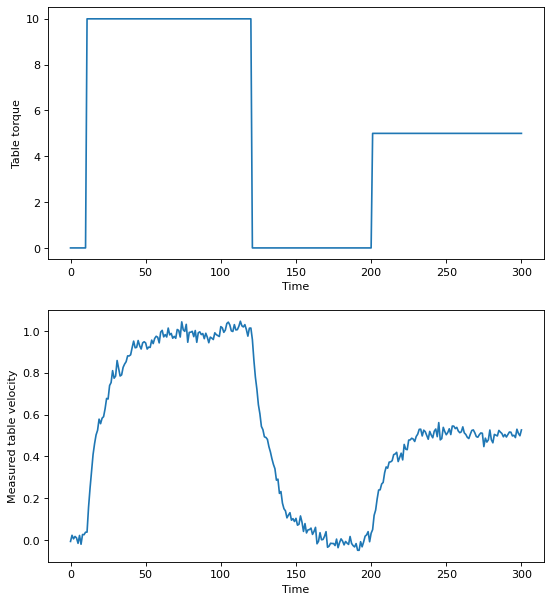

In [3]:
## Load Data
data=np.asarray(pd.read_csv("HW2_Data.csv",header=None))

t = data[:,0]      # t   : time vector [sec]
y_m = data[:,1]    # y_m : measured table velocity [radians/sec]
Torq = data[:,2]   # Torq: table torque [N-m]
omega_B_true = data[:,3]    # \omega_B : true rotational speed of bit [radians/sec]

# Plot Data
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, Torq)
plt.xlabel('Time')
plt.ylabel('Table torque')
# Plot table torque

plt.subplot(2,1,2)
plt.plot(t, y_m)
plt.xlabel('Time')
plt.ylabel('Measured table velocity')
# Plot measured table velocity

plt.show()

Eigenvalues of open-loop system:
[-0.08338525+0.29860789j -0.08338525-0.29860789j -0.08322949+0.j        ]
[[-39. ]
 [  0.5]
 [  0.6]]
Luenberger Observer RMSE: 0.09721100839999443


Text(0.5, 1.0, 'Estimated Error rate')

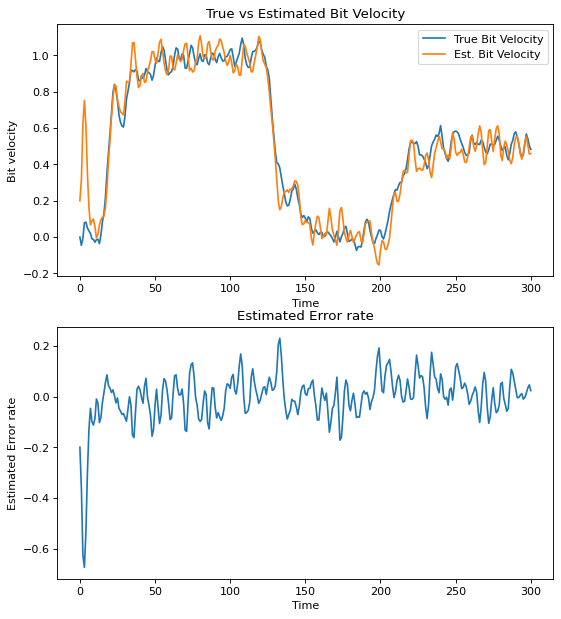

In [4]:
## Problem 4 - Luenberger Observer

# Eigenvalues of open-loop system
print('Eigenvalues of open-loop system:')
lam_A = np.linalg.eig(A)[0]
print(lam_A)

# Desired poles of estimation error system
#   They should have negative real parts
#   Complex conjugate pairs
lam_luen = 3*lam_A

# Compute observer gain (See Remark 3.1 in Notes. Use "acker" command)
L = control.acker(A.T, C.T, lam_luen).T
print(L)


# State-space Matrices for Luenberger Observer
A_lobs = A - L @ C
B_lobs = np.hstack([B, L])
C_lobs = C
D_lobs = np.matrix([0, 0])

sys_lobs = signal.lti(A_lobs, B_lobs, C_lobs, D_lobs)

# Inputs to observer
u = np.vstack([Torq, y_m]).T 

# Initial Conditions
x_hat0 = [0, 0.2, 0.2]

# Simulate Response
tsim, y, x_hat = signal.lsim(sys_lobs, U=u, T=t, X0=x_hat0)

# Parse states
theta_hat = x_hat[:,0]
omega_T_hat = x_hat[:,1]
omega_B_hat = x_hat[:,2]

# Compute RMSE
est_error = omega_B_true - omega_B_hat
RMSE = np.sqrt(np.mean(est_error ** 2))
print('Luenberger Observer RMSE:', RMSE)

# Plot Results
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
# Plot true and estimated bit velocity
plt.plot(t,omega_B_true,label='True Bit Velocity')
plt.plot(t,omega_B_hat, label='Est. Bit Velocity')

plt.xlabel('Time')
plt.ylabel('Bit velocity')
plt.title('True vs Estimated Bit Velocity')
plt.legend()

plt.subplot(2,1,2)
# Plot error between true and estimated bit velocity
plt.plot(t, omega_B_true - omega_B_hat)
plt.xlabel('Time')
plt.ylabel('Estimated Error rate')
plt.title('Estimated Error rate')



/var/folders/pn/xc8kcmsd72d8lpfzv60wn_lh0000gn/T/ipykernel_62886/3172084848.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iTorq = interp(it, t, Torq)
/var/folders/pn/xc8kcmsd72d8lpfzv60wn_lh0000gn/T/ipykernel_62886/3172084848.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iy_m = interp(it, t, y_m)


Kalman Filter RMSE: 0.0560851807030011 rad/s


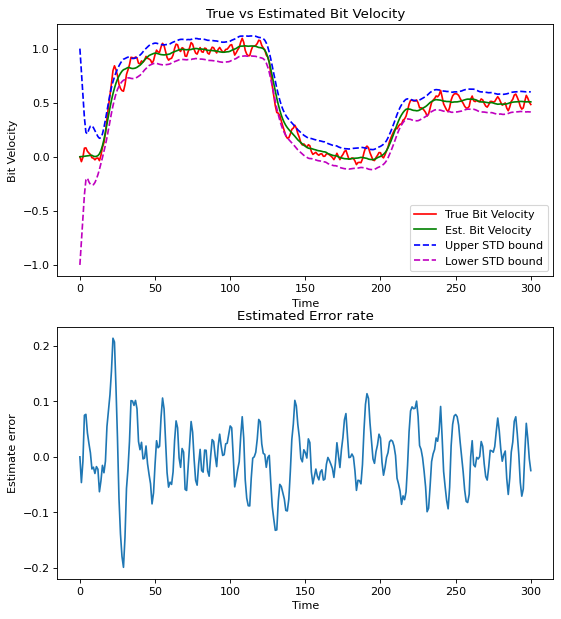

In [11]:
## Problem 5 - Kalman Filter

# Noise Covariances
W = np.matrix([[0.003, 0.005, 0.001], 
               [0.002, 0.003, 0.004], 
               [0.004, 0.001, 0.003]]) #You design this one. 
N = 0.02
Sig0 = np.identity(3)

# Initial Condition
x_hat0 = [0, 0, 0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_kf(z,it):
    
    # Parse States
    x_hat = np.matrix(z[:3]).T
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Kalman Gain
    L = Sig @ C.T / N 
    
    # Kalman Filter
    x_hat_dot = A @ x_hat + B * iTorq + L @ (iy_m - C @ x_hat)
    
    # Riccati Equation
    Sig_dot = Sig @ A.T + A @ Sig + W - Sig @ C.T / N @ C @ Sig
    
    # Concatenate LHS
    z_dot = np.r_[x_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Kalman Filter ODEs
z = odeint(ode_kf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:, 1]
omega_B_hat = z[:, 2]
Sig33 = z[:, -1]     # Parse out the (3,3) element of Sigma only!

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma
plt.plot(t,omega_B_true,'r', label='True Bit Velocity')
plt.plot(t,omega_B_hat, 'g', label='Est. Bit Velocity')
plt.plot(t,omega_B_hat_upperbound, 'b--', label='Upper STD bound')
plt.plot(t,omega_B_hat_lowerbound, 'm--', label='Lower STD bound')

plt.title('True vs Estimated Bit Velocity')
plt.xlabel('Time')
plt.ylabel('Bit Velocity')
plt.legend()


plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(t,omega_B_tilde)
plt.title('Estimated Error rate')
plt.xlabel('Time')
plt.ylabel('Estimate error')


plt.show()

In [18]:
# Compute eig(A-L(300)C)
Sig = np.matrix((z[-1, 3:]).reshape(3,3))
L = Sig @ C.T / N 
np.linalg.eig(A - L @ C)[0]

array([-0.09629086+0.29246942j, -0.09629086-0.29246942j,
       -0.21220948+0.j        ])

/var/folders/pn/xc8kcmsd72d8lpfzv60wn_lh0000gn/T/ipykernel_62102/2257718948.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iTorq = interp(it, t, Torq)
/var/folders/pn/xc8kcmsd72d8lpfzv60wn_lh0000gn/T/ipykernel_62102/2257718948.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iy_m = interp(it, t, y_m)


Extended Kalman Filter RMSE: 0.04562132030990834 rad/s


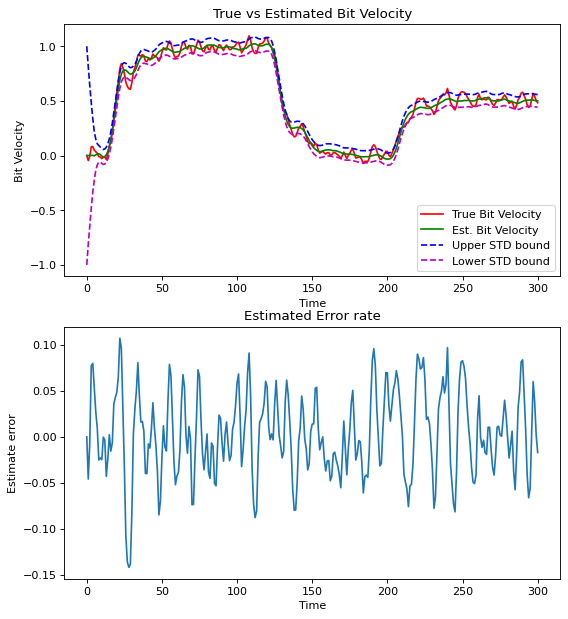

In [31]:
## Problem 6 - Extended Kalman Filter

# New nonlinear spring parameters
k1 = 2
k2 = 0.25

# Noise Covariances
W =   0.001 * np.identity(3) #You design this one. 
N = 0.02
Sig0 = np.identity(3)

# Initial Condition
x_hat0 = [0, 0, 0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_ekf(z,it):
    
    # Parse States
    theta_hat = z[0]
    omega_T_hat = z[1]
    omega_B_hat = z[2]
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Jacobians
    F = np.matrix([[0, -1, -1], 
                   [(-k1-3*k2*theta_hat**2)/J_T, -b/J_T, 0], 
                   [(k1+3*k2*theta_hat**2)/J_T, 0, -b/J_B]])# YOU DERIVE THESE
    H = np.matrix([[0,1,0]])
    
    # Compute Kalman Gain
    L = Sig * H.T /N
    
    # Compute EKF system matrices
    y_hat = omega_T_hat

    f = np.matrix([[omega_T_hat - omega_B_hat], [(-k1 * theta_hat - k2 * theta_hat ** 2 - b * omega_T_hat + iTorq) / J_T], [(k1 * theta_hat + k2 * theta_hat ** 2 - b * omega_B_hat) / J_B]])
    x_dot = f + L * (iy_m - omega_T_hat)
    
    theta_hat_dot = x_dot[0]
    omega_T_hat_dot = x_dot[1]
    omega_B_hat_dot = x_dot[2]
    
    # Riccati Equation
    Sig_dot = Sig @ F.T + F @ Sig + W - Sig @ H.T / N @ H @ Sig
    
    # Concatenate LHS
    z_dot = np.r_[theta_hat_dot, omega_T_hat_dot, omega_B_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Extended Kalman Filter ODEs
z = odeint(ode_ekf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:, 1]
omega_B_hat =  z[:,2]
Sig33 = z[:,-1]

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Extended Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')


# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma

plt.plot(t,omega_B_true,'r', label='True Bit Velocity')
plt.plot(t,omega_B_hat, 'g', label='Est. Bit Velocity')
plt.plot(t,omega_B_hat_upperbound, 'b--', label='Upper STD bound')
plt.plot(t,omega_B_hat_lowerbound, 'm--', label='Lower STD bound')

plt.title('True vs Estimated Bit Velocity')
plt.xlabel('Time')
plt.ylabel('Bit Velocity')
plt.legend()

plt.subplot(2,1,2)
#   Plot error between true and estimated bit velocity
plt.plot(t,omega_B_tilde)
plt.title('Estimated Error rate')
plt.xlabel('Time')
plt.ylabel('Estimate error')

plt.show()